In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import radians, cos, sin, asin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
from sys import hexversion


def single_pt_haversine(lat, lng, degrees=True):
    """
    'Single-point' Haversine: Calculates the great circle distance
    between a point on Earth and the (0, 0) lat-long coordinate
    """
    r = 6371 # Earth's radius (km). Have r = 3956 if you want miles

    # Convert decimal degrees to radians
    if degrees:
        lat, lng = map(radians, [lat, lng])

    # 'Single-point' Haversine formula
    a = sin(lat/2)**2 + cos(lat) * sin(lng/2)**2
    d = 2 * r * asin(sqrt(a)) 

    return d
def compute_herversine(data):
  haversitines=[]
  for row_id,row in data.iterrows():
    haversitines.append(single_pt_haversine(row['latitude'],row['longitude']))
  return haversitines


In [ ]:
data=pd.read_excel("/content/DS - Assignment Part 1 data set.xlsx")

In [ ]:
data.head()

,Transaction date,House Age,Distance from nearest Metro station (km),Number of convenience stores,latitude,longitude,Number of bedrooms,House size (sqft),House price of unit area
0,2012.916667,32.0,84.87882,10,24.98298,121.54024,1,575,37.9
1,2012.916667,19.5,306.59470,9,24.98034,121.53951,2,1240,42.2
2,2013.583333,13.3,561.98450,5,24.98746,121.54391,3,1060,47.3
3,2013.500000,13.3,561.98450,5,24.98746,121.54391,2,875,54.8
4,2012.833333,5.0,390.56840,5,24.97937,121.54245,1,491,43.1



## observation
*   the data has 9 columns where 8 are independent variables 
*   The target variable is called house price pre unit area 
*   Independent variables include 'Transaction date', 'House Age',
       'Distance from nearest Metro station (km)',
       'Number of convenience stores', 'latitude', 'longitude',
       'Number of bedrooms', 'House size (sqft)'



#EDA

###look for null values

In [ ]:
data.isna().sum()

Transaction date                            0
House Age                                   0
Distance from nearest Metro station (km)    0
Number of convenience stores                0
latitude                                    0
longitude                                   0
Number of bedrooms                          0
House size (sqft)                           0
House price of unit area                    0
dtype: int64

No null values in any of the data column

### check for distribution of target variable

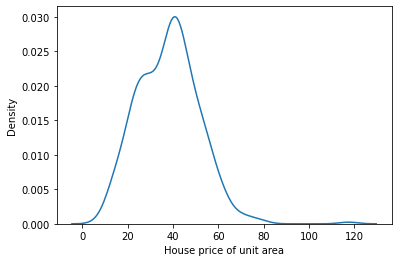

In [ ]:
sns.kdeplot(data['House price of unit area'])

 house prices seeems to be normally distributed with right skew

## check the relation ship of the dependent with target variable

### trnsaction date

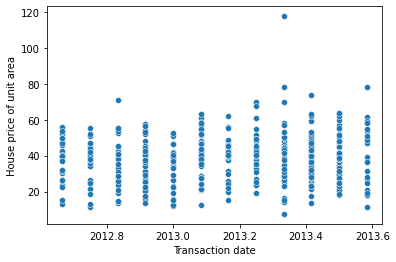

In [ ]:
sns.scatterplot(x=data['Transaction date'],y=data["House price of unit area"])

In [ ]:
data['Transaction date'].corr(data["House price of unit area"])

0.08752927169725978

There seems to be no relation ship between date and house prices which is quiet intutuive hence we might be able to drop the column when building the model,but there is also slight positive correlation between target 

### house age

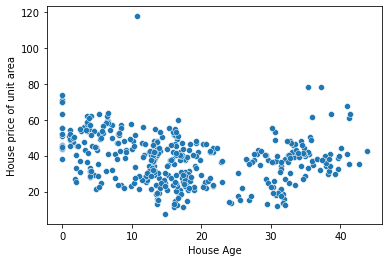

In [ ]:
sns.scatterplot(x=data['House Age'],y=data["House price of unit area"])

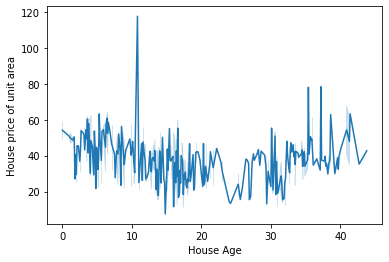

In [ ]:
sns.lineplot(x=data['House Age'],y=data["House price of unit area"])

In [ ]:
data['House Age'].corr(data["House price of unit area"])

-0.21056704627721692



*   From scatter plot it is not quiet clear what realtion between two variables is but  from line plot it seems to have some negative corellation
*   This is confirmed by actually calculation the corellation
* This seems reasonable since as the house ages it demand falls
* but there is an intresting pattern in the line plot i.e the value of house starts increasing after mid 20s age 



### Distance from nearest Metro station (km) 

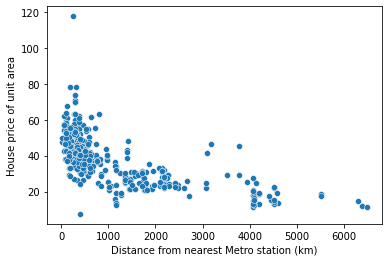

In [ ]:
sns.scatterplot(x=data['Distance from nearest Metro station (km)'],y=data["House price of unit area"])

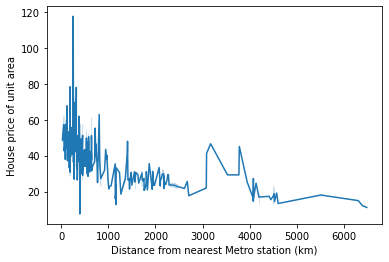

In [ ]:
sns.lineplot(x=data['Distance from nearest Metro station (km)'],y=data["House price of unit area"])

In [ ]:
data['Distance from nearest Metro station (km)'].corr(data["House price of unit area"])

-0.6736128553689185



*   So from above plots we can safely conclude that the varibles are negatively correlated 
*   From this we can tell that the closer the house to metro station more costly it is



### Number of convenience stores

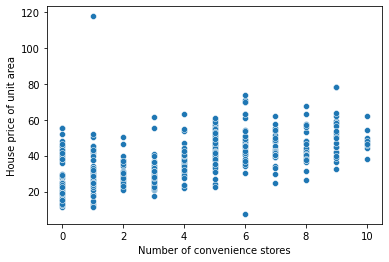

In [ ]:
sns.scatterplot(x=data['Number of convenience stores'],y=data["House price of unit area"])

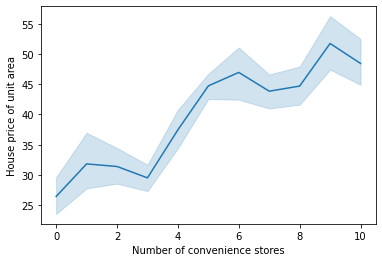

In [ ]:
sns.lineplot(x=data['Number of convenience stores'],y=data["House price of unit area"])

In [ ]:
data['Number of convenience stores'].corr(data["House price of unit area"])

0.5710049111111483



*   The house price is positive corellated with respect number of convinece stores 
*   that is more number of stores better is the house price
*   the thing to notes is that the house prices plateau after 4 or 5 stores  hence realtion is not linear



### latitude

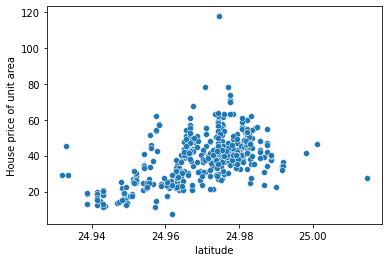

In [ ]:
sns.scatterplot(x=data['latitude'],y=data["House price of unit area"])

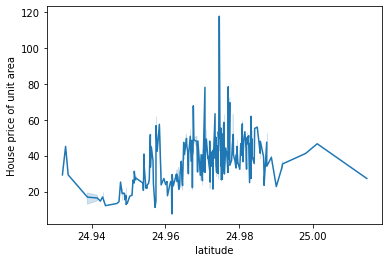

In [ ]:
sns.lineplot(x=data['latitude'],y=data["House price of unit area"])

In [ ]:
data['latitude'].corr(data["House price of unit area"])

0.5463066525036047



*   Latitude is positively corellated



### longitude




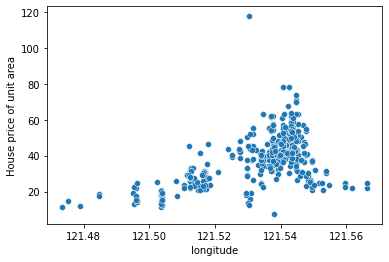

In [ ]:
sns.scatterplot(x=data['longitude'],y=data["House price of unit area"])

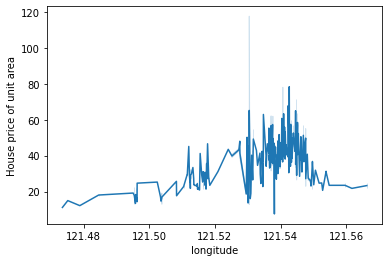

In [ ]:
sns.lineplot(x=data['longitude'],y=data["House price of unit area"])

In [ ]:
data['longitude'].corr(data["House price of unit area"])

0.5232865070287566



*   even longitude is positively corellated




### Number of bedrooms 

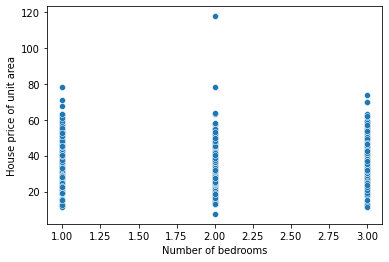

In [ ]:
sns.scatterplot(x=data['Number of bedrooms'],y=data["House price of unit area"])

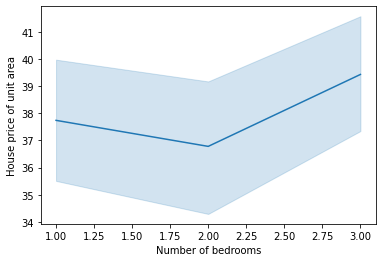

In [ ]:
sns.lineplot(x=data['Number of bedrooms'],y=data["House price of unit area"])

In [ ]:
data['Number of bedrooms'].corr(data["House price of unit area"])

0.050264787033188936



*   The number of bedrooms is postively corelated to house prices 
*   but it is very weakly corealted to the house price 




### House size (sqft)

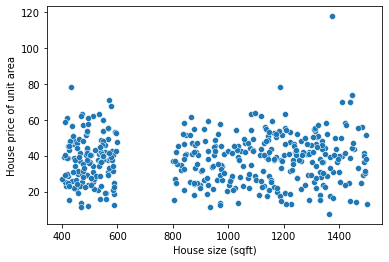

In [ ]:
sns.scatterplot(x=data['House size (sqft)'],y=data["House price of unit area"])

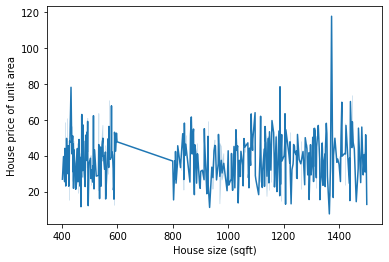

In [ ]:
sns.lineplot(x=data['House size (sqft)'],y=data["House price of unit area"])

In [ ]:
data['House size (sqft)'].corr(data["House price of unit area"])

0.04648915045713676



*   The house size is weakly corelated to price




### hervistine distance (converting longitude and latitude into single feature)

In [ ]:
herversine=compute_herversine(data)

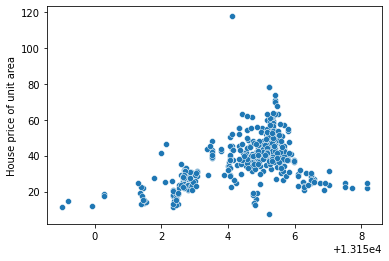

In [ ]:
sns.scatterplot(x=herversine,y=data["House price of unit area"])

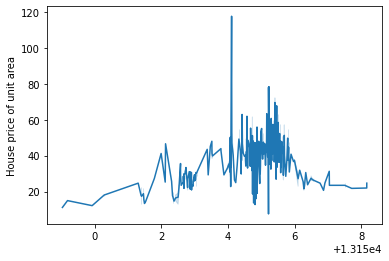

In [ ]:
sns.lineplot(x=herversine,y=data["House price of unit area"])

In [ ]:
data["herversine"]=herversine

In [ ]:
data['herversine'].corr(data["House price of unit area"])

0.4275572195902641



*   The hervisine is very highly corellated
*   Hence a useful feature



## Training model

In [ ]:
train,test=train_test_split(data,test_size=0.2,random_state=0)

In [ ]:
y_train=train['House price of unit area']
y_test=test["House price of unit area"]

In [ ]:
X_train=train.drop(labels=["House price of unit area"],axis=1)
X_test=test.drop(labels=["House price of unit area"],axis=1)

In [ ]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
X_train

array([[ 1.2196313 , -0.07552232,  0.94057325, ...,  1.25111844,
         0.36145855, -1.1755053 ],
       [ 0.92323056, -1.13888517,  0.93091517, ...,  0.02952492,
         1.6014433 , -1.40963845],
       [ 1.2196313 ,  1.85625352, -0.53058532, ...,  0.02952492,
         0.6191921 ,  0.02870294],
       ...,
       [-0.55877382, -0.33250168,  2.46031475, ...,  1.25111844,
         0.79960558, -1.46296131],
       [ 1.51603203,  1.64358095, -0.3705762 , ...,  1.25111844,
        -0.1740545 ,  0.15417011],
       [ 1.51603203, -0.95279667, -0.80857511, ...,  1.25111844,
        -0.24564715,  0.60200626]])

## Linear Regression

In [ ]:
l_model=LinearRegression()

In [ ]:
l_model.fit(X_train,y_train)

LinearRegression()

In [ ]:
mean_absolute_error(y_test,l_model.predict(X_test))

5.349394834116835

In [ ]:
mean_absolute_percentage_error(y_test,l_model.predict(X_test))

0.1614644380143732

# Tree Regressor

In [ ]:

tree_model = DecisionTreeRegressor()

In [ ]:
tree_model.fit(X_train,y_train)

DecisionTreeRegressor()

In [ ]:
mean_absolute_error(y_test,tree_model.predict(X_test))

6.949397590361445

In [ ]:
mean_absolute_percentage_error(y_test,tree_model.predict(X_test))

0.18256611337586648

## Gradient boosting

In [ ]:
xgb=XGBRegressor()

In [ ]:
xgb.fit(X_train,y_train)

[05:08:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
mean_absolute_error(y_test,xgb.predict(X_test))

4.534872084927846

In [ ]:
mean_absolute_percentage_error(y_test,xgb.predict(X_test))

0.12427689941598383

## Random forest

In [ ]:
rf_model= RandomForestRegressor()
rf_model.fit(X_train,y_train)

RandomForestRegressor()

In [ ]:
mean_absolute_error(y_test,rf_model.predict(X_test))

4.6772650602409644

In [ ]:
mean_absolute_percentage_error(y_test,rf_model.predict(X_test))

0.1314934286981707

# Model results

*   Linear regression is the second worst performing model, it basically assmes the target variables are linearly dependent on the independent variable which is obiously a false assumption as we have seen in the EDA

* Tree regressor does not work efficient because a single is not able to catch all the complexity of that data even though the tree is non linear model
*   The problem of non linear dependence can be solved by using tree based models like Random Forest which Performs much better than the linear regression since it is much more felixible in catching non linear patterns in the data 

*  The gradient boosting performs only sligly better than the random forest since it is optimized on minimizing the residual error 

* advantage of linear regression and Decision tree over the other models is that it is more interpreteble compared to RF and Gradient boosting  and also Linear regression is much more faster during the inferernce time 


